# Multi-Step Machine Learning Approach
In this file, we build a model with multiple steps. This multi-tiered approach allows us to tackle the problem from a macro (city-wide) level and then drill down to micro factors influencing individual or grouped shelter demands.


I am thinking we should use SARIMA for the the initial model (just predicting the overall shelter demand). Then, we can create regression models for each subgroup (e.g., postal code, organization) that predict the deviation from the city-wide average based on historical data.

## Imports

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data

### Shelter Data

In [ ]:
# for india
shelter_paths = ['/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv', '/content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv']

# # for nida
# shelter_paths = ['/content/drive/MyDrive/Datasets/daily-shelter-overnight-service-occupancy-capacity-2021.csv', '/content/drive/MyDrive/Datasets/daily-shelter-overnight-service-occupancy-capacity-2022.csv', '/content/drive/MyDrive/Datasets/daily-shelter-overnight-service-occupancy-capacity-2023.csv']


dataframes = [pd.read_csv(file) for file in shelter_paths]

# Load each file and verify its contents
for file in shelter_paths:
    try:
        df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(df)} rows from {file}")
            dataframes.append(df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

# If all DataFrames are loaded correctly, concatenate them into one
if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

Loaded 50944 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2021.csv
Loaded 49478 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2022.csv
Loaded 48345 rows from /content/drive/MyDrive/Colab Notebooks/Borealis Project/daily-shelter-overnight-service-occupancy-capacity-2023.csv
The combined dataframe has 297534 rows.


## SARIMA Modelling

**Background**

SARIMA stands for Seasonal AutoRegressive Integrated Moving Average. It is an extension of ARIMA that supports univariate time series data with a seasonal component. The model is specified with the notations SARIMA(p, d, q)(P, D, Q)m, where:

    * p: Order of the autoregressive part.
    * d: Degree of first differencing involved.
    * q: Order of the moving average part.
    * P: Seasonal autoregressive order.
    * D: Seasonal difference order.
    * Q: Seasonal moving average order.
    * m: The number of time steps for a single seasonal period.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

### Data Preparation

In [ ]:
combined_df = combined_df.dropna(subset=['CAPACITY_TYPE'])

combined_total_df = combined_df
combined_total_df['OCCUPANCY_RATE'] = np.where(combined_df['OCCUPANCY_RATE_BEDS'].isna(),
                                       combined_df['OCCUPANCY_RATE_ROOMS'],
                                       combined_df['OCCUPANCY_RATE_BEDS'])

In [ ]:
# Extract year, month, and day as separate features
combined_total_df['OCCUPANCY_DATE'] = pd.to_datetime(combined_total_df['OCCUPANCY_DATE'],format='mixed')
combined_total_df['YEAR'] = combined_total_df['OCCUPANCY_DATE'].dt.year
combined_total_df['MONTH'] = combined_total_df['OCCUPANCY_DATE'].dt.month
combined_total_df['DAY'] = combined_total_df['OCCUPANCY_DATE'].dt.day

In [ ]:
daily_city_average = combined_total_df.groupby('OCCUPANCY_DATE')['OCCUPANCY_RATE'].mean().reset_index()
print(daily_city_average.head())

  OCCUPANCY_DATE  OCCUPANCY_RATE
0     2021-01-01       93.056809
1     2021-01-02       93.206667
2     2021-01-03       92.847589
3     2021-01-04       92.394965
4     2021-01-05       92.289859


### Model

In [ ]:
daily_city_average.set_index('OCCUPANCY_DATE', inplace=True)
daily_city_average.index = pd.to_datetime(daily_city_average.index)

y = daily_city_average['OCCUPANCY_RATE'] # Target Variable: OCCUPANCY RATE

decomposition = seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

NameError: name 'seasonal_decompose' is not defined

In [ ]:
# # Finding The Best Parameters
# # found the following method online

# !pip install pmdarima
# from pmdarima import auto_arima

# # Auto ARIMA model
# y = daily_city_average['OCCUPANCY_RATE']
# auto_arima_model = auto_arima(y, start_p=0, start_q=0,
#                               test='adf',       # Use adftest to find optimal 'd'
#                               max_p=3, max_q=3, # Maximum p and q
#                               m=12,              # Frequency of the series
#                               d=None,           # Let model determine 'd'
#                               seasonal=True,   # No Seasonality
#                               start_P=0,
#                               D=1,
#                               trace=True,
#                               error_action='ignore',
#                               suppress_warnings=True,
#                               stepwise=True)

# print(auto_arima_model.summary())

# # TAKES A REALLY LONG TIME TO RUN
# # RESULTS FROM INITIAL RUN:
# #     p, d, q = 3, 0, 0
# #     P, D, Q, m = 2, 1, 0, 12

In [ ]:
# applying parameters to SARIMA
p, d, q = 3, 0, 0
P, D, Q, m = 2, 1, 0, 12

city_model = SARIMAX(y,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False)

city_results = city_model.fit()

# Summary of the model
print(city_results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                     OCCUPANCY_RATE   No. Observations:                 1095
Model:             SARIMAX(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -510.568
Date:                            Wed, 17 Apr 2024   AIC                           1033.136
Time:                                    15:46:16   BIC                           1062.909
Sample:                                01-01-2021   HQIC                          1044.422
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7065      0.024     29.200      0.000       0.659       0.754
ar.L2          0.0553      0.034   

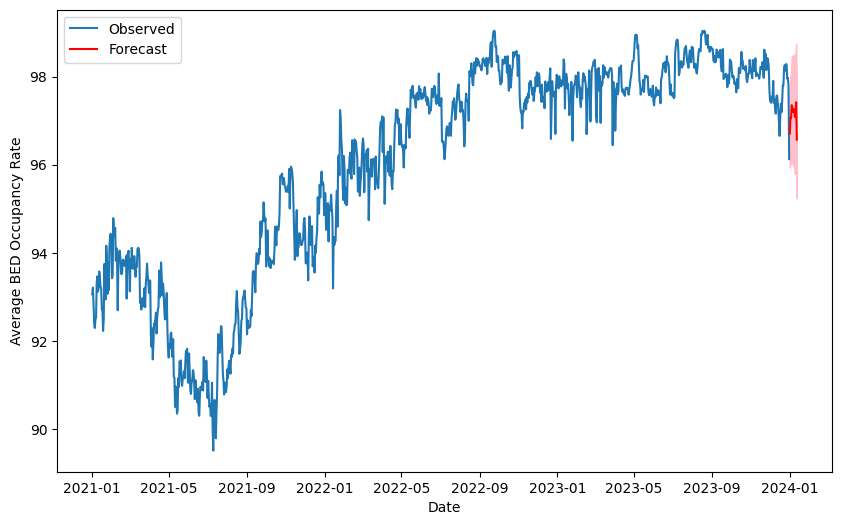

In [ ]:
# City Forecast
city_forecast = city_results.get_forecast(steps=12)
city_mean_forecast = city_forecast.predicted_mean
city_conf_int = city_forecast.conf_int()

# Plot the forecast including the confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Observed')
plt.plot(city_mean_forecast.index, city_mean_forecast, color='red', label='Forecast')
plt.fill_between(city_conf_int.index, city_conf_int.iloc[:, 0], city_conf_int.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('Average BED Occupancy Rate')
plt.legend()
plt.show()

### Training and Testing

In [ ]:
split_point = int(len(y) * 0.8)
city_y_train, city_y_test = y.iloc[:split_point], y.iloc[split_point:]



city_model_train = SARIMAX(city_y_train,
                                 order=(p, d, q),
                                 seasonal_order=(P, D, Q, m),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
city_training_results = city_model_train.fit()

# Forecast
city_forecast_training = city_training_results.get_forecast(steps=len(city_y_test))
city_predictions_training = city_forecast_training.predicted_mean

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Metrics without weather data
mae_city = mean_absolute_error(city_y_test, city_predictions_training)
mse_city = mean_squared_error(city_y_test, city_predictions_training)
rmse_city = np.sqrt(mse_city)
mape_city = mean_absolute_percentage_error(city_y_test, city_predictions_training)

# Print the metrics to compare
print(f"MAE: {mae_city}, MSE: {mse_city}, RMSE: {rmse_city}, MAPE: {mape_city}%")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 0.42491919424562674, MSE: 0.26320616134808406, RMSE: 0.513036218358981, MAPE: 0.4327077496079315%


## Regression Models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

### Postal Code

In [ ]:
# Data Prep

postal_code_data = combined_total_df

postal_code_data['DAY_OF_WEEK'] = postal_code_data['OCCUPANCY_DATE'].dt.dayofweek
postal_code_data['MONTH'] = postal_code_data['OCCUPANCY_DATE'].dt.month

grouped_data = postal_code_data.groupby(['LOCATION_POSTAL_CODE', 'OCCUPANCY_DATE']).agg({
    'OCCUPANCY_RATE': 'mean',
    'DAY_OF_WEEK': 'first',  # since all entries per day should be the same
    'MONTH': 'first'
}).reset_index()

grouped_data.head()

,LOCATION_POSTAL_CODE,OCCUPANCY_DATE,OCCUPANCY_RATE,DAY_OF_WEEK,MONTH
0,L4L 8P5,2021-01-01,100.0,4,1
1,L4L 8P5,2021-01-02,100.0,5,1
2,L4L 8P5,2021-01-03,100.0,6,1
3,L4L 8P5,2021-01-04,100.0,0,1
4,L4L 8P5,2021-01-05,100.0,1,1


In [ ]:
# Prepare the feature matrix and target vector
postal_X = postal_code_data[['DAY_OF_WEEK', 'MONTH']]
postal_y = postal_code_data['OCCUPANCY_RATE']

# Split the dataset
X_train_postal, X_test_postal, y_train_postal, y_test_postal = train_test_split(postal_X, postal_y, test_size=0.2, random_state=4)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train_postal, y_train_postal)

# Predict and evaluate the model
postal_predictions = model.predict(X_test_postal)
postal_mse = mean_squared_error(y_test_postal, postal_predictions)
print(f'Mean Squared Error: {postal_mse}')

Mean Squared Error: 114.00911407793936


In [ ]:
# Initialize the Random Forest model
rf_model_postal = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model_postal.fit(X_train_postal, y_train_postal)

# Predict and evaluate the model
rf_predictions_postal = rf_model_postal.predict(X_test_postal)
rf_mse_postal = mean_squared_error(y_test_postal, rf_predictions_postal)
print(f'Random Forest Mean Squared Error: {rf_mse_postal}')

Random Forest Mean Squared Error: 113.89820301891064


### Shelter Types

In [50]:
# Data Prep

sector_data = combined_total_df

sector_data['DAY_OF_WEEK'] = sector_data['OCCUPANCY_DATE'].dt.dayofweek
sector_data['MONTH'] = sector_data['OCCUPANCY_DATE'].dt.month

sector_grouped_data = sector_data.groupby(['SECTOR', 'OCCUPANCY_DATE']).agg({
    'OCCUPANCY_RATE': 'mean',
    'DAY_OF_WEEK': 'first',  # since all entries per day should be the same
    'MONTH': 'first'
}).reset_index()

sector_grouped_data.head()

,SECTOR,OCCUPANCY_DATE,OCCUPANCY_RATE,DAY_OF_WEEK,MONTH
0,Families,2021-01-01,91.113529,4,1
1,Families,2021-01-02,91.103529,5,1
2,Families,2021-01-03,91.108824,6,1
3,Families,2021-01-04,91.134706,0,1
4,Families,2021-01-05,90.962941,1,1


In [51]:
# Prepare the feature matrix and target vector
X_sector = sector_grouped_data[['DAY_OF_WEEK', 'MONTH']]
y_sector = sector_grouped_data['OCCUPANCY_RATE']

# Split the dataset
X_train_sector, X_test_sector, y_train_sector, y_test_sector = train_test_split(X_sector, y_sector, test_size=0.2, random_state=42)

In [53]:
# Initialize and train the linear regression model
model_sector = LinearRegression()
model_sector.fit(X_train_sector, y_train_sector)

# Predict and evaluate the model
predictions_sector = model_sector.predict(X_test_sector)
mse_sector = mean_squared_error(y_test_sector, predictions_sector)
print(f'Mean Squared Error: {mse_sector}')

Mean Squared Error: 11.231634545176927


In [54]:
# Initialize the Random Forest model
rf_model_sector = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model_sector.fit(X_train_sector, y_train_sector)

# Predict and evaluate the model
rf_predictions_sector = rf_model_sector.predict(X_test_sector)
rf_mse_sector = mean_squared_error(y_test_sector, rf_predictions_sector)
print(f'Random Forest Mean Squared Error: {rf_mse_sector}')

Random Forest Mean Squared Error: 11.467874610769623


### Capacity Type

In [ ]:
# Data Prep

capacity_data = combined_total_df

capacity_data['DAY_OF_WEEK'] = capacity_data['OCCUPANCY_DATE'].dt.dayofweek
capacity_data['MONTH'] = capacity_data['OCCUPANCY_DATE'].dt.month

capacity_grouped_data = capacity_data.groupby(['CAPACITY_TYPE', 'OCCUPANCY_DATE']).agg({
    'OCCUPANCY_RATE': 'mean',
    'DAY_OF_WEEK': 'first',  # since all entries per day should be the same
    'MONTH': 'first'
}).reset_index()

capacity_grouped_data.head()

,CAPACITY_TYPE,OCCUPANCY_DATE,OCCUPANCY_RATE,DAY_OF_WEEK,MONTH
0,Bed Based Capacity,2021-01-01,93.077159,4,1
1,Bed Based Capacity,2021-01-02,93.174659,5,1
2,Bed Based Capacity,2021-01-03,92.600568,6,1
3,Bed Based Capacity,2021-01-04,92.620455,0,1
4,Bed Based Capacity,2021-01-05,92.356932,1,1


In [ ]:
# Prepare the feature matrix and target vector
X_capacity = capacity_grouped_data[['DAY_OF_WEEK', 'MONTH']]
y_capacity = capacity_grouped_data['OCCUPANCY_RATE']

# Split the dataset
X_train_capacity, X_test_capacity, y_train_capacity, y_test_capacity = train_test_split(X_capacity, y_capacity, test_size=0.2, random_state=42)

In [ ]:
# Initialize and train the linear regression model
model_capacity = LinearRegression()
model.fit(X_train_capacity, y_train_capacity)

# Predict and evaluate the model
predictions_capacity = model.predict(X_test_capacity)
mse_capacity = mean_squared_error(y_test_capacity, predictions_capacity)
print(f'Mean Squared Error: {mse_capacity}')

Mean Squared Error: 6.797647437962082


In [ ]:
# Initialize the Random Forest model
rf_model_capacity = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model_capacity.fit(X_train_capacity, y_train_capacity)

# Predict and evaluate the model
rf_predictions_capacity = rf_model_capacity.predict(X_test_capacity)
rf_mse_capacity = mean_squared_error(y_test_capacity, rf_predictions_capacity)
print(f'Random Forest Mean Squared Error: {rf_mse_capacity}')

Random Forest Mean Squared Error: 7.3092803515389475


### Weather
The Vector Autoregression (VAR) model is a statistical method used to capture the linear interdependencies among multiple time series data by allowing each variable in a system to be modeled as a linear function of past values of itself and the other variables. The principle behind VAR is that it provides insights into how each variable influences others within the dataset, enabling more accurate forecasting and understanding of dynamic interactions across variables.

We can use VAR to see how changes in weather, such as temperature and precipitation, might influence how many people use shelters. It considers past trends in weather and shelter occupancy to make these predictions.

In [ ]:
weather_file_paths = ['/content/drive/MyDrive/Datasets/en_climate_daily_ON_6158355_2021_P1D.csv', '/content/drive/MyDrive/Datasets/en_climate_daily_ON_6158355_2022_P1D.csv', '/content/drive/MyDrive/Datasets/en_climate_daily_ON_6158355_2023_P1D.csv', '/content/drive/MyDrive/Datasets/en_climate_daily_ON_6158355_2024_P1D.csv']

dataframes = [pd.read_csv(file) for file in weather_file_paths]

for file in weather_file_paths:
    try:
        weather_df = pd.read_csv(file)
        if df.empty:
            print(f"The file at {file} is empty.")
        else:
            print(f"Loaded {len(weather_df)} rows from {file}")
            dataframes.append(weather_df)
    except FileNotFoundError:
        print(f"No file found at {file}")
    except pd.errors.EmptyDataError:
        print(f"File at {file} is empty or corrupted.")

if dataframes:
    combined_weather_df = pd.concat(dataframes, ignore_index=True)
    print(f"The combined dataframe has {len(combined_weather_df)} rows.")
else:
    print("No data has been loaded. Please check the file paths and contents.")

Loaded 365 rows from /content/drive/MyDrive/Datasets/en_climate_daily_ON_6158355_2021_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Datasets/en_climate_daily_ON_6158355_2022_P1D.csv
Loaded 365 rows from /content/drive/MyDrive/Datasets/en_climate_daily_ON_6158355_2023_P1D.csv
Loaded 366 rows from /content/drive/MyDrive/Datasets/en_climate_daily_ON_6158355_2024_P1D.csv
The combined dataframe has 2922 rows.


In [ ]:

# Removing unnecessary columns
columns_to_drop = ['Longitude (x)', 'Latitude (y)', 'Station Name', 'Climate ID', 'Data Quality', 'Max Temp Flag', 'Min Temp Flag', 'Mean Temp Flag', 'Heat Deg Days (°C)', 'Heat Deg Days Flag', 'Cool Deg Days (°C)', 'Cool Deg Days Flag', 'Total Rain (mm)', 'Total Rain Flag', 'Total Snow (cm)', 'Total Snow Flag', 'Total Precip Flag', 'Snow on Grnd (cm)', 'Snow on Grnd Flag', 'Dir of Max Gust (10s deg)', 'Dir of Max Gust Flag', 'Spd of Max Gust (km/h)', 'Spd of Max Gust Flag']

weather_df = combined_weather_df.drop(columns_to_drop, axis=1)

print(weather_df.head())

# Combine the Year, Month, Day columns to form a 'Date' column
weather_df['Date'] = pd.to_datetime(weather_df[['Year', 'Month', 'Day']])

# Set 'Date' as the index
weather_df.set_index('Date', inplace=True)


# Drop the original Year, Month, Day columns as they are no longer needed
weather_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Now, your DataFrame should only have 'Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)', 'Total Precip (mm)'
# Check data
print(weather_df.head())

    Date/Time  Year  Month  Day  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
0  2021-01-01  2021      1    1            2.5           -1.0             0.7   
1  2021-01-02  2021      1    2            2.2           -0.9             0.7   
2  2021-01-03  2021      1    3            2.1            0.2             1.1   
3  2021-01-04  2021      1    4            1.7           -0.1             0.8   
4  2021-01-05  2021      1    5            1.6            0.6             1.1   

   Total Precip (mm)  
0                6.8  
1               10.8  
2                1.7  
3                0.0  
4                0.4  
             Date/Time  Max Temp (°C)  Min Temp (°C)  Mean Temp (°C)  \
Date                                                                   
2021-01-01  2021-01-01            2.5           -1.0             0.7   
2021-01-02  2021-01-02            2.2           -0.9             0.7   
2021-01-03  2021-01-03            2.1            0.2             1.1   
2021-01-04  202

In [ ]:
# Convert 'OCCUPANCY_DATE' to datetime if not already done
combined_total_df['OCCUPANCY_DATE'] = pd.to_datetime(combined_total_df['OCCUPANCY_DATE'])

# Set 'OCCUPANCY_DATE' as the index of the dataframe
combined_total_df.set_index('OCCUPANCY_DATE', inplace=True)

In [ ]:
# Assuming combined_total_df is already prepared and properly indexed by date
combined_df = pd.merge(combined_total_df, weather_df, left_index=True, right_index=True, how='left')

# Check the combined DataFrame
print(combined_df.head())


                _id  ORGANIZATION_ID         ORGANIZATION_NAME  SHELTER_ID  \
OCCUPANCY_DATE                                                               
2021-01-01        1               24  COSTI Immigrant Services          40   
2021-01-01        1               24  COSTI Immigrant Services          40   
2021-01-01        2               24  COSTI Immigrant Services          40   
2021-01-01        2               24  COSTI Immigrant Services          40   
2021-01-01        3               24  COSTI Immigrant Services          40   

                         SHELTER_GROUP  LOCATION_ID  \
OCCUPANCY_DATE                                        
2021-01-01      COSTI Reception Centre       1103.0   
2021-01-01      COSTI Reception Centre       1103.0   
2021-01-01      COSTI Reception Centre       1103.0   
2021-01-01      COSTI Reception Centre       1103.0   
2021-01-01      COSTI Reception Centre       1103.0   

                                           LOCATION_NAME LOCATION_A

In [ ]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
combined_df.dropna(subset=['OCCUPANCY_RATE', 'Mean Temp (°C)', 'Total Precip (mm)'], inplace=True)



In [ ]:
# Assuming stationarity or after making data stationary
model = VAR(combined_df[['OCCUPANCY_RATE', 'Mean Temp (°C)', 'Total Precip (mm)']])
results = model.fit(maxlags=15, ic='aic')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Forecasting the next 5 steps
lag_order = results.k_ar
forecasted_values = results.forecast(combined_df[['OCCUPANCY_RATE', 'Mean Temp (°C)', 'Total Precip (mm)']].values[-lag_order:], steps=5)
forecasted_values_df = pd.DataFrame(forecasted_values, columns=['OCCUPANCY_RATE', 'Mean Temp (°C)', 'Total Precip (mm)'])

print(forecasted_values_df)

   OCCUPANCY_RATE  Mean Temp (°C)  Total Precip (mm)
0       97.922942        0.300851           2.299403
1       96.991149        0.301746           2.298761
2       96.980679        0.302711           2.298140
3       96.832125        0.303599           2.297500
4       96.507261        0.304484           2.296841


In [ ]:
# Define the split point, typically hold out the last few observations for testing
split_point = int(len(combined_df) * 0.8)
train, test = combined_df.iloc[:split_point], combined_df.iloc[split_point:]

# Fit the VAR model on the training data
model = VAR(train[['OCCUPANCY_RATE', 'Mean Temp (°C)', 'Total Precip (mm)']])
results = model.fit(maxlags=15, ic='aic')

# Forecast the test dataset
forecasted_values = results.forecast(train[['OCCUPANCY_RATE', 'Mean Temp (°C)', 'Total Precip (mm)']].values[-results.k_ar:], steps=len(test))
forecasted_values_df = pd.DataFrame(forecasted_values, index=test.index, columns=['OCCUPANCY_RATE', 'Mean Temp (°C)', 'Total Precip (mm)'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error



# Calculate metrics for 'OCCUPANCY_RATE'
rmse = mean_squared_error(test['OCCUPANCY_RATE'], forecasted_values_df['OCCUPANCY_RATE'])

print(f'Vector Autoregression Model Mean Squared Error: {rmse}')


Vector Autoregression Model Mean Squared Error: 53.30212223936081


# Combining the Models Together

## Full Prediction Model for Data

In [ ]:
y = daily_city_average['OCCUPANCY_RATE'] # Target Variable: OCCUPANCY RATE

In [ ]:
# applying parameters to SARIMA
p, d, q = 3, 0, 0
P, D, Q, m = 2, 1, 0, 12

city_model_full = SARIMAX(y,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False)

city_full_results = city_model_full.fit()

# Forecast for the full date range present in your dataset
city_full_forecast = city_full_results.get_prediction(start=df['OCCUPANCY_DATE'].min(), end=df['OCCUPANCY_DATE'].max())
city_full_predictions = city_full_forecast.predicted_mean


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


### Average + Postal Code

In [ ]:
postal_code_predictions = rf_model_postal.predict(postal_X)

In [ ]:
# Convert the index of city-wide predictions to a DataFrame
city_predictions_df = city_full_predictions.reset_index()
city_predictions_df.columns = ['OCCUPANCY_DATE', 'CITY_PREDICTIONS']

# Merge city-wide predictions with postal code data
postal_code_data = pd.merge(postal_code_data, city_predictions_df, on='OCCUPANCY_DATE', how='left')

In [ ]:
# Calculate the difference as a percentage
postal_code_data['PERCENT_DIFF'] = ((postal_code_data['OCCUPANCY_RATE'] - postal_code_data['CITY_PREDICTIONS']) / postal_code_data['CITY_PREDICTIONS']) * 100

# Group by postal code to find average difference per postal code
average_difference_by_postal_code = postal_code_data.groupby('LOCATION_POSTAL_CODE')['PERCENT_DIFF'].mean().reset_index()
print(average_difference_by_postal_code)

    LOCATION_POSTAL_CODE  PERCENT_DIFF
0                L4L 8P5     -0.580868
1                M1B 3M6      1.950321
2                M1E 2M6      1.788946
3                M1E 2N8      1.652000
4                M1E 2P4      1.937915
..                   ...           ...
116              M8Y 1A3      1.996329
117              M9V 1P9     -5.334910
118              M9V 2X6      1.926341
119              M9W 1J1      1.943663
120              M9W 6P8      2.016795

[121 rows x 2 columns]


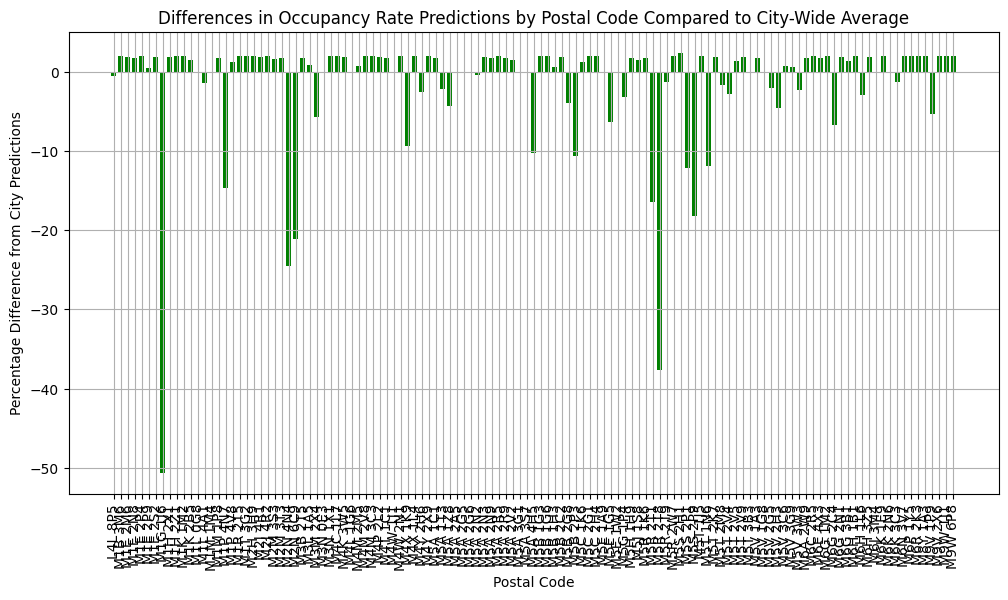

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(average_difference_by_postal_code['LOCATION_POSTAL_CODE'], average_difference_by_postal_code['PERCENT_DIFF'], color='green')
plt.xlabel('Postal Code')
plt.ylabel('Percentage Difference from City Predictions')
plt.title('Differences in Occupancy Rate Predictions by Postal Code Compared to City-Wide Average')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [47]:
def adjusted_postal_code_predictions(start_date, end_date, postal_code, city_model, adjustment_factors):
    # Convert dates to string format if the model's date index expects that
    start_str = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    end_str = pd.to_datetime(end_date).strftime('%Y-%m-%d')

    # Assuming the index of the SARIMAX model is a datetime index
    # Generate city-wide predictions from SARIMAX model
    city_forecast = city_model.get_prediction(start=start_str, end=end_str)
    city_predictions = city_forecast.predicted_mean

    # Convert city-wide predictions to DataFrame
    city_pred_df = city_predictions.to_frame(name='CITY_PREDICTIONS').reset_index()
    city_pred_df.rename(columns={'index': 'OCCUPANCY_DATE'}, inplace=True)

    # Apply the adjustment factor for the specified postal code
    # Assuming 'adjustment_factors' is a dictionary with postal codes as keys and adjustment percentages as values
    if postal_code in adjustment_factors:
        city_pred_df['ADJUSTED_PREDICTIONS'] = city_pred_df['CITY_PREDICTIONS'] * (1 + adjustment_factors[postal_code] / 100)
    else:
        city_pred_df['ADJUSTED_PREDICTIONS'] = city_pred_df['CITY_PREDICTIONS']  # No adjustment if postal code not found

    return city_pred_df


In [48]:
# Example: Generate predictions from Jan 1, 2024, to Jan 31, 2024, for postal code 'M3L 1A5'
start_date = '2024-06-01'
end_date = '2024-07-01'
postal_code = 'M3L 1A5'
adjustment_factors = {
    'M3L 1A5': average_difference_by_postal_code.loc[average_difference_by_postal_code['LOCATION_POSTAL_CODE'] == 'M3L 1A5', 'PERCENT_DIFF'].iloc[0]
}

# Assuming 'city_full_results' is your trained SARIMAX model object
adjusted_predictions = adjusted_postal_code_predictions(start_date, end_date, postal_code, city_full_results, adjustment_factors)
print(adjusted_predictions)

   OCCUPANCY_DATE  CITY_PREDICTIONS  ADJUSTED_PREDICTIONS
0      2024-06-01         97.219231             98.079445
1      2024-06-02         97.375900             98.237501
2      2024-06-03         97.477936             98.340440
3      2024-06-04         96.486129             97.339857
4      2024-06-05         96.893666             97.751000
5      2024-06-06         97.178588             98.038443
6      2024-06-07         97.175005             98.034828
7      2024-06-08         97.528411             98.391362
8      2024-06-09         97.540503             98.403560
9      2024-06-10         97.434260             98.296378
10     2024-06-11         97.495855             98.358517
11     2024-06-12         97.430906             98.292993
12     2024-06-13         97.219494             98.079711
13     2024-06-14         97.376156             98.237759
14     2024-06-15         97.478058             98.340563
15     2024-06-16         96.485993             97.339720
16     2024-06

### Average + Capacity Type

In [55]:
predictions_sector = rf_model_sector.predict(X_sector)

In [56]:
# Merge city-wide predictions with postal code data
sector_data = pd.merge(sector_data, city_predictions_df, on='OCCUPANCY_DATE', how='left')

In [58]:
# Calculate the difference as a percentage
sector_data['PERCENT_DIFF'] = ((sector_data['OCCUPANCY_RATE'] - sector_data['CITY_PREDICTIONS']) / sector_data['CITY_PREDICTIONS']) * 100

# Group by postal code to find average difference per postal code
average_difference_by_sector = sector_data.groupby('SECTOR')['PERCENT_DIFF'].mean().reset_index()
print(average_difference_by_sector)

        SECTOR  PERCENT_DIFF
0     Families      1.062018
1          Men      0.145593
2  Mixed Adult      0.097006
3        Women      1.379565
4        Youth     -2.556067


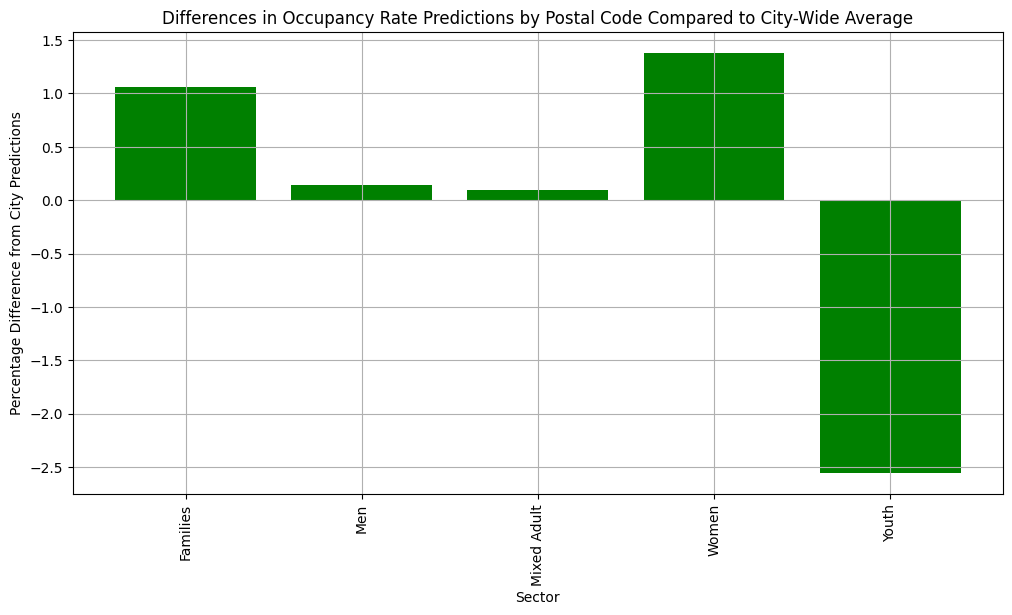

In [59]:
plt.figure(figsize=(12, 6))
plt.bar(average_difference_by_sector['SECTOR'], average_difference_by_sector['PERCENT_DIFF'], color='green')
plt.xlabel('Sector')
plt.ylabel('Percentage Difference from City Predictions')
plt.title('Differences in Occupancy Rate Predictions by Postal Code Compared to City-Wide Average')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()